In [1]:
import allensdk_lims.internal.core.lims_utilities as lu
from allensdk.core.nwb_data_set import NwbDataSet
from allensdk.ephys.extract_cell_features import extract_cell_features

import os
import numpy as np
import pandas as pd
from collections import defaultdict
import json
import pg8000


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



In [176]:
#create dataframe that contains all the metadata of the experiments plus the ephys features from showcase work
#this might be easiest to just do from a spreadsheet
donor_df = pd.read_csv('donor_info.csv')

#convert date string to usable format
from datetime import datetime
for i,date in enumerate(donor_df['Collection_Date']):
    donor_df['Collection_Date'][i] = datetime.strptime(date,"%m/%d/%Y")

df = pd.read_csv('custom_report.csv')


In [177]:
def LinuxtoWindow(Linuxpath):
    SplitLinux = Linuxpath.split('/')
    return (r"\\" + os.path.join('titan','cns', SplitLinux[2], SplitLinux[4],SplitLinux[5],''))

def get_spec_name(specimen):
    conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
    cur = conn.cursor()
    
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + specimen,))
    result = cur.fetchone()
    if result is None:
        print "Could not find specimen result for " + specimen + ". Skipping..."
        return None
    specimen_name = result[0]
    ephys_roi_result_id = result[1]


    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%ephys_features.json'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()
    if result is None:
        print "Could not find json file for " + specimen + ". Skipping..."
        return None
    WinP = LinuxtoWindow(result[1])
    json_path = WinP + result[0]

    return json_path
    conn.close()
    cur.close()

def json_feature_parse(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
    path = data['specimens'][0]['cell_ephys_features']
    specimen_id = data['id']
    
    features = []
    tau = path['long_squares']['tau']
    features.append(tau)
    sag = path['long_squares']['sag']
    features.append(sag)
    ri = path['long_squares']['input_resistance']
    features.append(ri)
    sag_amp =path['long_squares']['v_baseline'] - (path['long_squares']['vm_for_sag']*sag)
    features.append(sag_amp)
    ISI_mean = path['long_squares']['hero_sweep']['mean_isi']
    features.append(ISI_mean)
    adaptation_index = path['long_squares']['hero_sweep']['adapt']
    features.append(adaptation_index)
    capacitance = tau/ri*1000
    features.append(capacitance)
    AP_LS_amp = path['long_squares']['hero_sweep']['spikes'][0]['peak_v'] - path['long_squares']['hero_sweep']['spikes'][0]['threshold_v']
    features.append(AP_LS_amp)
    AP_SS_amp = path['short_squares']['mean_spike_0']['peak_v'] - path['short_squares']['mean_spike_0']['threshold_v']
    features.append(AP_SS_amp)
    upstroke_downstroke_ratio = path['long_squares']['rheobase_sweep']['spikes'][0]['upstroke_downstroke_ratio']
    features.append(upstroke_downstroke_ratio)
    v_rest = path['long_squares']['v_baseline']
    features.append(v_rest)
    rheobase_sweep = path['long_squares']['rheobase_sweep']['id']
    features.append(rheobase_sweep)
    ss_latency= path['short_squares']['common_amp_sweeps'][0]['latency']
    features.append(ss_latency)
    ls_latency = path['long_squares']['hero_sweep']['latency']
    features.append(ls_latency)
    instant_sweep = path['short_squares']['common_amp_sweeps'][0]['id']
    features.append(instant_sweep)
    rheobase_i = path['long_squares']['rheobase_i']
    features.append(rheobase_i)
    hero_rate = path['long_squares']['hero_sweep']['avg_rate']
    features.append(hero_rate)
    spikes = path['long_squares']['hero_sweep']['spikes']
    fast_trough = path['long_squares']['hero_sweep']['spikes'][0]['fast_trough_v']
    features.append(fast_trough)
    hero_sweep = path['long_squares']['hero_sweep']['id']
    features.append(hero_sweep)
    hero_ap_peak_t = path['long_squares']['hero_sweep']['spikes'][0]['peak_t']
    features.append(hero_ap_peak_t)
    hero_ap_threshold_v = path['long_squares']['hero_sweep']['spikes'][0]['threshold_v']
    features.append(hero_ap_threshold_v)
    IH = {i['id']:i['stim_amp'] for i in path['long_squares']['subthreshold_membrane_property_sweeps'] }
    features.append(IH)

    return features  

In [178]:
#SQL query from David to get NWB file paths
query = """
select wkf.storage_directory || wkf.filename as nwb_path, sp.id as specimen_id, sp.name as specimen_name
from well_known_files wkf 
join ephys_roi_results err on wkf.attachable_id = err.id
join specimens sp on sp.ephys_roi_result_id = err.id
where wkf.well_known_file_type_id = 475137571
and err.workflow_state = 'manual_passed'

"""
nwb_files = lu.query(query)

nwb_df = pd.DataFrame(nwb_files)

for i,cell in enumerate(df['cell_specimen_id']):
    try:
        df['nwb_filename'][i] = nwb_df['nwb_path'][nwb_df.specimen_id == cell].iloc[0]
        df['nwb_filename'][i] = lu.linux_to_windows(df['nwb_filename'][i])
    except IndexError:
        pass

In [179]:
new_columns = ['tau','sag','ri','sag_amp','ISI_mean','adaptation_index',
               'capacitance','AP_amp_LS','AP_amp_SS','upstroke_downstroke_ratio','v_rest',
               'rheobase_sweep','ss_latency','ls_latency','instant_sweep','rheobase_i', 
               'hero_rate','fast_trough','hero_sweep',
               'hero_ap_peak_t','hero_ap_threshold_v','layer','dendrite_type',
              'surgeon', 'hospital', 'surgery', 'surgery_date','donor', 'json_path']

for key in new_columns:
    df[key] = None

for i,cell in enumerate(df['cell_specimen_name']):
    if df['ephys_qc'][i] == 'manual_passed':
        df['donor'][i] = cell[:10]
        df['surgeon'][i] = donor_df['Surgeon'][donor_df.Specimen_ID_Number == df['donor'][i]].iloc[0]
        df['hospital'][i] = donor_df['Hospital_ID'][donor_df.Specimen_ID_Number == df['donor'][i]].iloc[0]
        df['surgery'][i] = donor_df['Surgery_type'][donor_df.Specimen_ID_Number == df['donor'][i]].iloc[0]
        df['surgery_date'][i] = donor_df['Collection_Date'][donor_df.Specimen_ID_Number == df['donor'][i]].iloc[0]
        df['json_path'].iloc[i] = str(get_spec_name(cell))
        json_features = json_feature_parse(df['json_path'].iloc[i])
        for j, heading in enumerate(new_columns[:-8]):
            #print heading
            df[heading][i] = json_features[j]

In [46]:
surgeons = {'Ko' : 'slategrey',
          'Cobbs' : 'firebrick',
          'Gwinn' : 'royalblue',
          'Ojemann' : 'darkorange'}

hospitals = {'Swedish' : 'darkviolet',
             'Harborview' : 'seagreen'}

surgerys = {'epilepsy' : 'crimson',
           'Tumor' : 'aqua',
           'other' : 'powderblue'}


In [185]:
new_columns = ['day', 'day_color', 'surgeon_color', 'hospital_color', 'surgery_color']

for key in new_columns:
    df[key] = None

for i in range(len(df)):
    df['surgeon_color'][i] = surgeons[df['surgeon'][i]]
    df['hospital_color'][i] = hospitals[df['hospital'][i]]
    df['surgery_color'][i] = surgerys[df['surgery'][i]]

In [227]:
df.to_pickle('human_data')

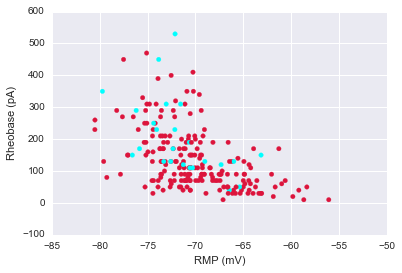

In [231]:
plt.scatter(df['v_rest'], df['rheobase_i'], color = df['surgery_color'])
plt.xlabel('RMP (mV)')
plt.ylabel('Rheobase (pA)')

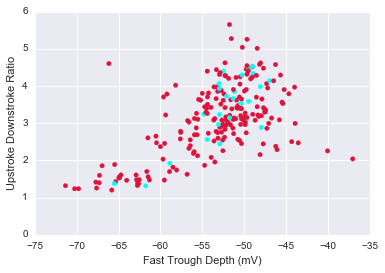

In [232]:
plt.scatter(df['fast_trough'], df['upstroke_downstroke_ratio'], color = df['surgery_color'])
plt.xlabel('Fast Trough Depth (mV)')
plt.ylabel('Upstroke Downstroke Ratio')

In [224]:
for i,date in enumerate(df['recording_date']):
    df['day'][i] = (date - df['surgery_date'][i]).days + 1 
    if df['day'][i] == 1:
        df['day_color'][i] = 'limegreen'
    elif df['day'][i] == 2:
        df['day_color'][i] = 'chocolate'
    elif df['day'][i] > 2:
        df['day_color'][i] = 'darkred'

In [215]:
if df['day'][0] > datetime.datetime(1:
    print 'day'

TypeError: can't compare datetime.timedelta to int

In [223]:
(date - df['surgery_date'][i]).days

0

In [219]:
datetime.timedelta?

Object `datetime.timedelta` not found.
